In [1]:
from tectosaur2.nb_config import setup

setup()

In [60]:
import sympy as sp
import numpy as np
import matplotlib.pyplot as plt
from tectosaur2 import gauss_rule, refine_surfaces, integrate_term, tensor_dot
from tectosaur2.elastic2d import elastic_t, elastic_h
from tectosaur2.mesh import panelize_symbolic_surface, concat_meshes
from tectosaur2.rate_state import MaterialProps, qd_equation, solve_friction, aging_law

In [39]:
surf_half_L = 500000
fault_length = 40000
max_panel_length = 800
n_decollement = 400
mu = shear_modulus = 3.2e10
nu = 0.25

qx, qw = gauss_rule(6)
sp_t = sp.var("t")

edges = np.linspace(-1, 1, n_decollement+1)
panel_bounds = np.stack((edges[:-1],edges[1:]), axis=1)
angle_rad = sp.pi / 10
sp_x = (sp_t + 1) / 2 * sp.cos(angle_rad) * fault_length
sp_y = -(sp_t + 1) / 2 * sp.sin(angle_rad) * fault_length
decollement = panelize_symbolic_surface(
    sp_t, sp_x, sp_y,
    panel_bounds,
    qx, qw
)

In [55]:
decollement_extension = refine_surfaces(
    [[
        sp_t,
        ((((sp_t + 1) / 2) * 1000) + 1) * sp.cos(angle_rad) * fault_length,
        -((((sp_t + 1) / 2) * 1000) + 1) * sp.sin(angle_rad) * fault_length
    ]],
    (qx, qw),
    control_points=np.array([[0,0,1e6, 4e4]])
)
decollement_extension.n_panels

46

In [ ]:
splay_fault_length = 20000
splay_offset = 10000
splay_angle_rad = sp.pi / 3
splay_sp_t = sp.var("t_s")
splay_sp_x = splay_offset + (splay_sp_t + 1) / 2 * sp.cos(splay_angle_rad)
splay_sp_y = -(splay_sp_t + 1) / 2 * sp.sin(splay_angle_rad)


In [40]:
result = sp.solve([splay_sp_x - sp_x,splay_sp_y - sp_y], sp_t, splay_sp_t)
splay_length = 0.5 * float(result[splay_sp_t])
splay_sp_x = splay_offset + (splay_sp_t + 1) / 2 * sp.cos(splay_angle_rad) * splay_length
splay_sp_y = -(splay_sp_t + 1) / 2 * sp.sin(splay_angle_rad) * splay_length
n_splay = int(splay_length / 100)

In [105]:

splay_edges = np.linspace(-1, 1, n_splay+1)
splay_panel_bounds = np.stack((splay_edges[:-1],splay_edges[1:]), axis=1)
splay = panelize_symbolic_surface(
    splay_sp_t, splay_sp_x, splay_sp_y,
    splay_panel_bounds,
    qx, qw
)
faults = decollement#concat_meshes((decollement, splay))

def sp_line(start, end):
    t01 = (sp_t + 1) * 0.5
    xv = start[0] + t01 * (end[0] - start[0])
    yv = start[1] + t01 * (end[1] - start[1])
    return sp_t, xv, yv

free1,free2,free3 = refine_surfaces(
    [
        sp_line([surf_half_L, 0], [splay_offset, 0]),
        sp_line([splay_offset, 0], [0, 0]),
        sp_line([0, 0], [-surf_half_L, 0]),
    ],
    (qx, qw),
    control_points = [
        # nearfield surface panels and fault panels will be limited to 200m
        # at 200m per panel, we have ~40m per solution node because the panels
        # have 5 nodes each
        (0, 0, 1.5 * fault_length, max_panel_length),
        (0, 0, 0.2 * fault_length, 1.5 * fault_length / (n_decollement)),
        (splay_offset, 0, 1.5 * fault_length, max_panel_length),
        (splay_offset, 0, 0.2 * fault_length, 1.5 * fault_length / (n_decollement)),
        # farfield panels will be limited to 200000 m per panel at most
        (0, 0, surf_half_L, 50000),
    ]
)
free = concat_meshes((free1, free2, free3))
print(
    f"The free surface mesh has {free.n_panels} panels with a total of {free.n_pts} points."
)
print(
    f"The splay mesh has {splay.n_panels} panels with a total of {splay.n_pts} points."
)
print(
    f"The decollement mesh has {decollement.n_panels} panels with a total of {decollement.n_pts} points."
)

The free surface mesh has 528 panels with a total of 3168 points.
The splay mesh has 46 panels with a total of 276 points.
The decollement mesh has 400 panels with a total of 2400 points.


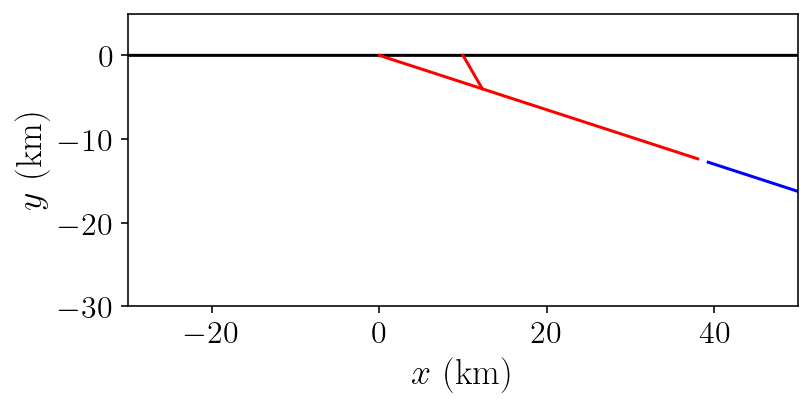

In [106]:
plt.plot(free.pts[:,0]/1000, free.pts[:,1]/1000, 'k-')
plt.plot(decollement.pts[:,0]/1000, decollement.pts[:,1]/1000, 'r-')
plt.plot(splay.pts[:,0]/1000, splay.pts[:,1]/1000, 'r-')
plt.plot(decollement_extension.pts[:,0]/1000, decollement_extension.pts[:,1]/1000, 'b-')
plt.xlabel(r'$x ~ \mathrm{(km)}$')
plt.ylabel(r'$y ~ \mathrm{(km)}$')
plt.axis('scaled')
plt.xlim([-30, 50])
plt.ylim([-30, 5])
plt.show()

And, to start off the integration, we'll construct the operators necessary for solving for free surface displacement from fault slip.

In [107]:
singularities = np.array(
    [
        [-surf_half_L, 0],
        [surf_half_L, 0],
        [float(sp_x.subs(sp_t,-1)), float(sp_y.subs(sp_t,-1))],
        [float(sp_x.subs(sp_t,1)), float(sp_y.subs(sp_t,1))],
        [float(splay_sp_x.subs(splay_sp_t,-1)), float(splay_sp_y.subs(splay_sp_t,-1))],
        [float(splay_sp_x.subs(splay_sp_t,1)), float(splay_sp_y.subs(splay_sp_t,1))],
    ]
)

In [108]:
(free_disp_to_free_disp, fault_slip_to_free_disp), report = integrate_term(
    elastic_t(nu), free.pts, free, faults, singularities=singularities, safety_mode=True, return_report=True
)

/Users/tbent/Dropbox/active/eq/tectosaur2/tectosaur2/integrate.py:174: UserWarning: Some integrals failed to converge during adaptive integration. This an indication of a problem in either the integration or the problem formulation.
  warnings.warn(
/Users/tbent/Dropbox/active/eq/tectosaur2/tectosaur2/integrate.py:180: UserWarning: Some expanded integrals reached maximum expansion order. These integrals may be inaccurate.
  warnings.warn(


In [109]:
fault_slip_to_free_disp = fault_slip_to_free_disp.reshape((-1, 2 * faults.n_pts))
free_disp_to_free_disp = free_disp_to_free_disp.reshape((-1, 2 * free.n_pts))
free_disp_solve_mat = (
    np.eye(free_disp_to_free_disp.shape[0]) + free_disp_to_free_disp
)

In [110]:
from tectosaur2.elastic2d import ElasticH

(free_disp_to_fault_stress, fault_slip_to_fault_stress), report = integrate_term(
    ElasticH(nu, d_cutoff=8.0),
    # elastic_h(nu),
    faults.pts,
    free,
    faults,
    tol=1e-12,
    safety_mode=True,
    singularities=singularities,
    return_report=True,
)
fault_slip_to_fault_stress *= shear_modulus
free_disp_to_fault_stress *= shear_modulus


In [111]:
A = -fault_slip_to_fault_stress.reshape((-1, 2 * faults.n_pts))
B = -free_disp_to_fault_stress.reshape((-1, 2 * free.n_pts))
C = fault_slip_to_free_disp
Dinv = np.linalg.inv(free_disp_solve_mat)
total_fault_slip_to_fault_stress = A - B.dot(Dinv.dot(C))

nx = faults.normals[:, 0]
ny = faults.normals[:, 1]
normal_mult = np.transpose(np.array([[nx, 0 * nx, ny], [0 * nx, ny, nx]]), (2, 0, 1))

total_fault_slip_to_fault_traction = np.sum(
    total_fault_slip_to_fault_stress.reshape((-1, 3, faults.n_pts, 2))[:, None, :, :, :]
    * normal_mult[:, :, :, None, None],
    axis=2,
).reshape((-1, 2 * faults.n_pts))



## Rate and state friction

Okay, now that we've constructed the necessary boundary integral operators, we get to move on to describing the frictional behavior on the fault.

#### TODO: Explain!!

In [112]:
siay = 31556952  # seconds in a year
density = 2670  # rock density (kg/m^3)
cs = np.sqrt(shear_modulus / density)  # Shear wave speed (m/s)
Vp = 1e-9  # Rate of plate motion
sigma_n0 = 50e6  # Normal stress (Pa)

# parameters describing "a", the coefficient of the direct velocity strengthening effect
a0 = 0.01
amax = 0.025
H = 15000
h = 3000
fx = faults.pts[:, 0]
fy = faults.pts[:, 1]
fd = -np.sqrt(fx ** 2 + fy ** 2)
a = np.where(
    fd > -H, a0, np.where(fd > -(H + h), a0 + (amax - a0) * (fd + H) / -h, amax)
)

mp = MaterialProps(a=a, b=0.015, Dc=0.008, f0=0.6, V0=1e-6, eta=shear_modulus / (2 * cs))

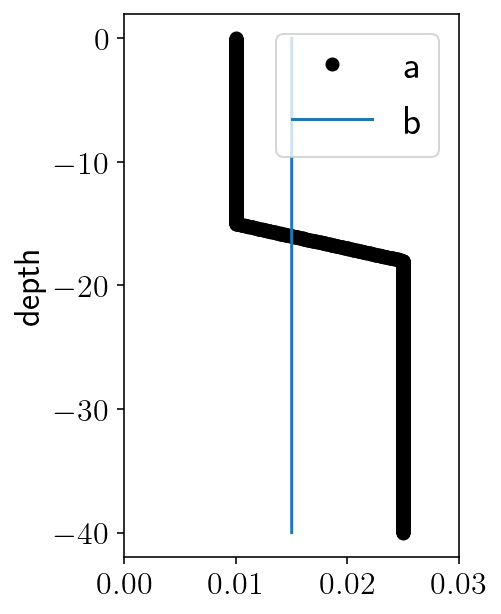

In [113]:
plt.figure(figsize=(3, 5))
plt.plot(mp.a, fd/1000, 'ko', label='a')
plt.plot(np.full(fy.shape[0], mp.b), fd/1000, label='b')
plt.xlim([0, 0.03])
plt.ylabel('depth')
plt.legend()
plt.show()

In [114]:
mesh_L = np.max(np.abs(np.diff(fd[:decollement.n_pts])))
Lb = shear_modulus * mp.Dc / (sigma_n0 * mp.b)
hstar = (np.pi * shear_modulus * mp.Dc) / (sigma_n0 * (mp.b - mp.a))
mesh_L, Lb, np.min(hstar[hstar > 0])

(23.861918608330598, 341.3333333333333, 3216.990877275949)

In [115]:
mesh_L = np.max(np.abs(np.diff(fd[decollement.n_pts:])))
Lb = shear_modulus * mp.Dc / (sigma_n0 * mp.b)
hstar = (np.pi * shear_modulus * mp.Dc) / (sigma_n0 * (mp.b - mp.a))
mesh_L, Lb, np.min(hstar[hstar > 0])

ValueError: zero-size array to reduction operation maximum which has no identity

## Quasidynamic earthquake cycle derivatives

In [116]:
from scipy.optimize import fsolve
import copy

init_state_scalar = fsolve(lambda S: aging_law(mp, Vp, S), 0.7)[0]
mp_amax = copy.copy(mp)
mp_amax.a=amax
tau_amax = -qd_equation(mp_amax, sigma_n0, 0, Vp, init_state_scalar)
init_state = np.log((2*mp.V0/Vp)*np.sinh((tau_amax - mp.eta*Vp) / (mp.a*sigma_n0))) * mp.a

init_tau = np.full(faults.n_pts, tau_amax)
init_sigma = np.full(faults.n_pts, sigma_n0)
init_slip = np.zeros(faults.n_pts)
init_conditions = np.concatenate((init_slip, init_state))

In [162]:
extension_slip_to_free_disp = integrate_term(
    elastic_t(nu), free.pts, decollement_extension, singularities=singularities, safety_mode=True
)
extension_slip_to_fault_stress = integrate_term(
    ElasticH(nu, d_cutoff=8.0),
    faults.pts,
    decollement_extension,
    tol=1e-12,
    safety_mode=True,
    singularities=singularities
)
extension_slip_to_fault_stress *= shear_modulus

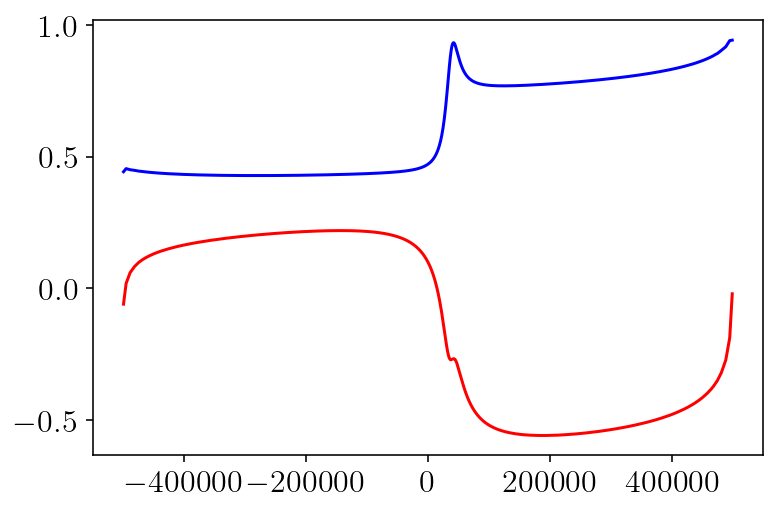

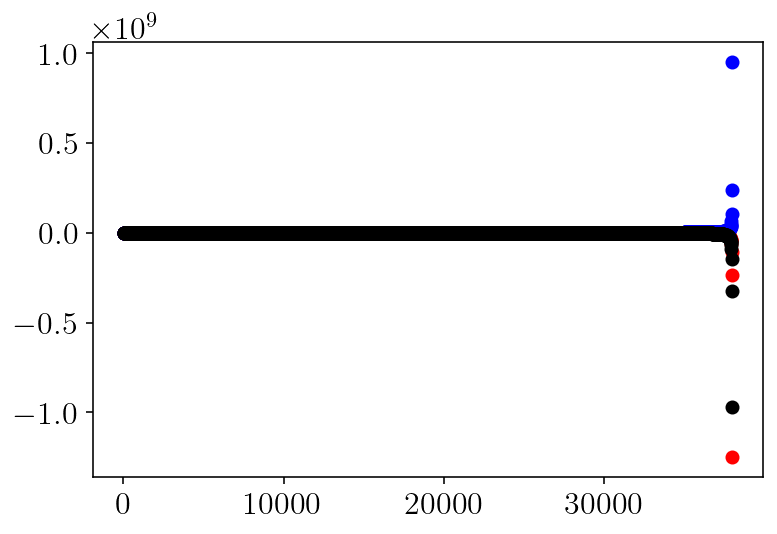

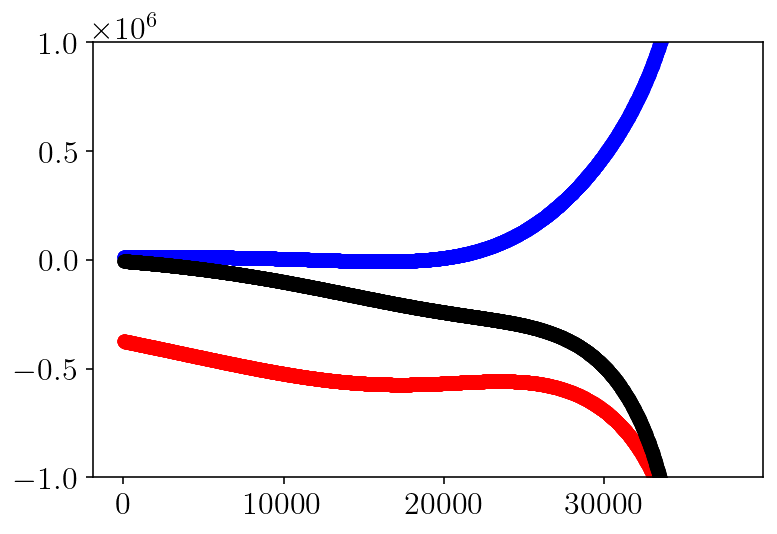

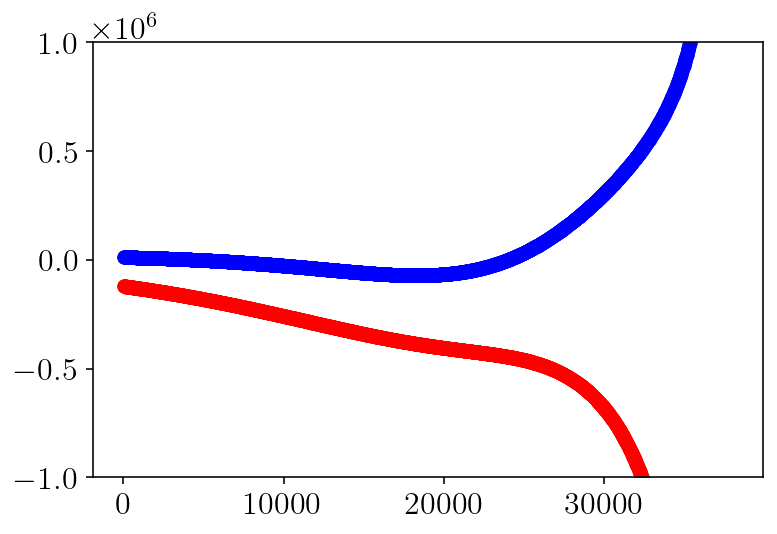

In [163]:
ext_nx = decollement_extension.normals[:, 0]
ext_ny = decollement_extension.normals[:, 1]
ext_slip = np.stack((-ext_ny, ext_nx), axis=1)
surf_disp = Dinv.dot(-tensor_dot(extension_slip_to_free_disp, ext_slip).ravel()).reshape((-1, 2))
extension_stress = -tensor_dot(free_disp_to_fault_stress, surf_disp) -tensor_dot(extension_slip_to_fault_stress, ext_slip)
extension_traction= np.sum(extension_stress[:,None,:] * normal_mult, axis=2)
plt.plot(free.pts[:, 0], surf_disp[:, 0], 'r-')
plt.plot(free.pts[:, 0], surf_disp[:, 1], 'b-')
plt.show()
plt.plot(faults.pts[:, 0], extension_stress[:, 0], 'ro')
plt.plot(faults.pts[:, 0], extension_stress[:, 1], 'bo')
plt.plot(faults.pts[:, 0], extension_stress[:, 2], 'ko')
plt.show()
plt.plot(faults.pts[:, 0], extension_stress[:, 0], 'ro')
plt.plot(faults.pts[:, 0], extension_stress[:, 1], 'bo')
plt.plot(faults.pts[:, 0], extension_stress[:, 2], 'ko')
plt.ylim([-1e6, 1e6])
plt.show()
plt.plot(faults.pts[:, 0], extension_traction[:, 0], 'ro')
plt.plot(faults.pts[:, 0], extension_traction[:, 1], 'bo')
plt.ylim([-1e6, 1e6])
plt.show()

In [164]:
class SystemState:

    V_old = np.full(faults.n_pts, Vp)
    state = None

    def calc(self, t, y, verbose=False):
        # Separate the slip_deficit and state sub components of the
        # time integration state.
        slip = y[: init_slip.shape[0]]
        state = y[init_slip.shape[0] :]

        # If the state values are bad, then the adaptive integrator probably
        # took a bad step.
        if np.any((state < 0) | (state > 2.0)):
            print("bad state")
            return False

        # The big three lines solving for quasistatic shear stress, slip rate
        # and state evolution
        traction = extension_traction * Vp * t 
        sd_vector = np.stack((slip * -ny, slip * nx), axis=1).ravel()
        traction += total_fault_slip_to_fault_traction.dot(sd_vector).reshape((-1, 2))
        delta_sigma_qs = np.sum(traction * np.stack((nx, ny), axis=1), axis=1)
        delta_tau_qs = -np.sum(traction * np.stack((-ny, nx), axis=1), axis=1)
        tau_qs = init_tau + delta_tau_qs
        sigma_qs = init_sigma + delta_sigma_qs

        # Need to properly handle the 
        # tau_sign = np.sign(tau_qs)
        # tau_abs = np.abs(tau_qs)
        V = solve_friction(mp, sigma_qs, tau_qs, self.V_old, state)
        if not V[2]:
            print("convergence failed")
            return False

        V = V[0]
        if not np.all(np.isfinite(V)):
            print("infinite V")
            return False
        dstatedt = aging_law(mp, V, state)
        self.V_old = V

        out = (
            slip,
            state,
            delta_sigma_qs,
            sigma_qs,
            delta_tau_qs,
            tau_qs,
            V,
            dstatedt
        )
        self.data = out
        return self.data

In [165]:
def plot_system_state(t, SS, xlim=None):
    """This is just a helper function that creates some rough plots of the
    current state to help with debugging"""
    (
        slip,
        state,
        delta_sigma_qs,
        sigma_qs,
        delta_tau_qs,
        tau_qs,
        V,
        dstatedt,
    ) = SS

    fd = -np.linalg.norm(faults.pts, axis=1)

    plt.figure(figsize=(15, 9))
    plt.suptitle(f"t={t/siay}")
    plt.subplot(3, 3, 1)
    plt.title("slip")
    plt.plot(fd, slip)
    plt.xlim(xlim)

    # plt.subplot(3, 3, 2)
    # plt.title("slip deficit")
    # plt.plot(fd, slip_deficit)
    # plt.xlim(xlim)

    # plt.subplot(3, 3, 2)
    # plt.title("slip deficit rate")
    # plt.plot(fd, slip_deficit_rate)
    # plt.xlim(xlim)

    # plt.subplot(3, 3, 2)
    # plt.title("strength")
    # plt.plot(fd, tau_qs/sigma_qs)
    # plt.xlim(xlim)

    plt.subplot(3, 3, 3)
    # plt.title("log V")
    # plt.plot(fd, np.log10(V))
    plt.title("V")
    plt.plot(fd, V)
    plt.xlim(xlim)

    plt.subplot(3, 3, 4)
    plt.title(r"$\sigma_{qs}$")
    plt.plot(fd, sigma_qs)
    plt.xlim(xlim)

    plt.subplot(3, 3, 5)
    plt.title(r"$\tau_{qs}$")
    plt.plot(fd, tau_qs, 'k-o')
    plt.xlim(xlim)

    plt.subplot(3, 3, 6)
    plt.title("state")
    plt.plot(fd, state)
    plt.xlim(xlim)

    plt.subplot(3, 3, 7)
    plt.title(r"$\Delta\sigma_{qs}$")
    plt.plot(fd, delta_sigma_qs)
    plt.hlines([0], [fd[-1]], [fd[0]])
    plt.xlim(xlim)

    plt.subplot(3, 3, 8)
    plt.title(r"$\Delta\tau_{qs}$")
    plt.plot(fd, delta_tau_qs)
    plt.hlines([0], [fd[-1]], [fd[0]])
    plt.xlim(xlim)

    plt.subplot(3, 3, 9)
    plt.title("dstatedt")
    plt.plot(fd, dstatedt)
    plt.xlim(xlim)
    plt.tight_layout()

    plt.show()

In [166]:
def calc_derivatives(state, t, y):
    """
    This helper function calculates the system state and then extracts the
    relevant derivatives that the integrator needs. It also intentionally
    returns infinite derivatives when the `y` vector provided by the integrator
    is invalid.
    """
    if not np.all(np.isfinite(y)):
        return np.inf * y
    state_vecs = state.calc(t, y)
    if not state_vecs:
        return np.inf * y
    derivatives = np.concatenate((state_vecs[-2], state_vecs[-1]))
    return derivatives


## Integrating through time


step=0, time=1.4631838620462974e-05 yrs, step=1.4631838620462974e-05
step=0, time=1.4631838620462974e-05 yrs, step=1.4631838620462974e-05


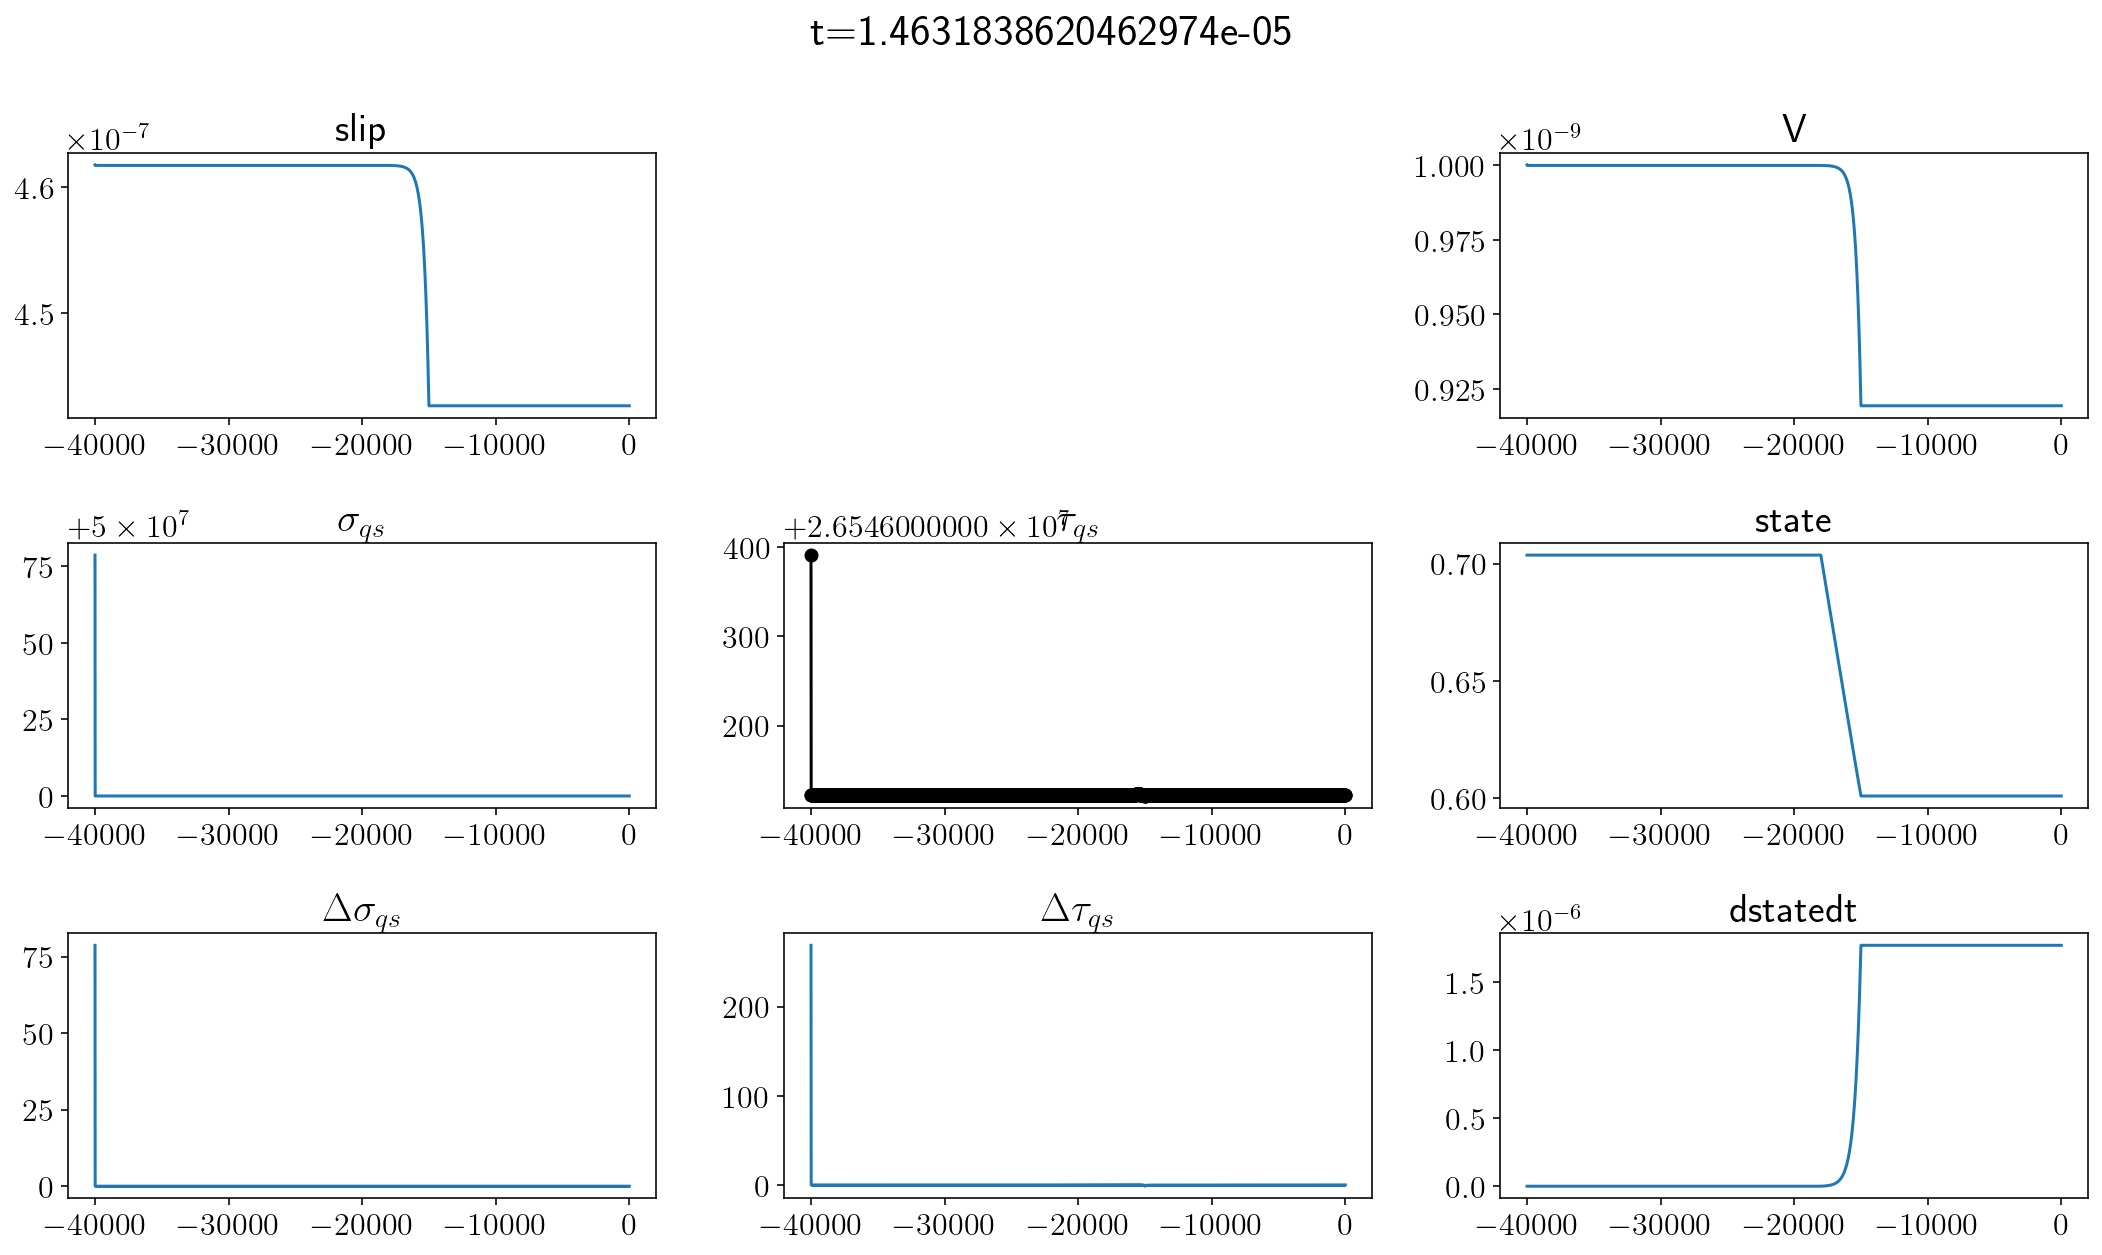

step=100, time=0.025554214512286327 yrs, step=0.00011925273201087714


KeyboardInterrupt: 

In [167]:
%%time
from scipy.integrate import RK23, RK45

# We use a 5th order adaptive Runge Kutta method and pass the derivative function to it
# the relative tolerance will be 1e-11 to make sure that even 
state = SystemState()
derivs = lambda t, y: calc_derivatives(state, t, y)
integrator = RK45
atol = Vp * 1e-6
rtol = 1e-11
rk = integrator(derivs, 0, init_conditions, 1e50, atol=atol, rtol=rtol)

# Set the initial time step to one day.
rk.h_abs = 60 * 60 * 24

# Integrate for 1000 years.
max_T = 300 * siay

n_steps = 50000
t_history = [0]
y_history = [init_conditions.copy()]
for i in range(n_steps):
    # Take a time step and store the result
    if rk.step() != None:
        raise Exception("TIME STEPPING FAILED")
    t_history.append(rk.t)
    y_history.append(rk.y.copy())

    # Print the time every 5000 steps
    if i % 1000 == 0:
        print(f"step={i}, time={rk.t / siay} yrs, step={(rk.t - t_history[-2]) / siay}")
    if i % 100 == 0:
        print(f"step={i}, time={rk.t / siay} yrs, step={(rk.t - t_history[-2]) / siay}")
        plot_system_state(rk.t, state.calc(rk.t, rk.y))#, xlim=[-21000, -14000])

    if rk.t > max_T:
        break

y_history = np.array(y_history)
t_history = np.array(t_history)

## Plotting the results

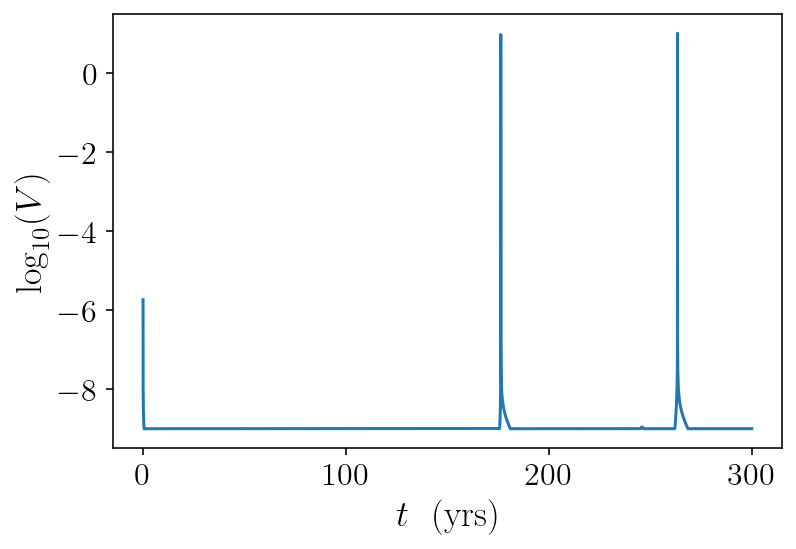

In [21]:
derivs_history = np.diff(y_history, axis=0) / np.diff(t_history)[:, None]
max_vel = np.max(np.abs(derivs_history), axis=1)
plt.plot(t_history[1:] / siay, np.log10(max_vel))
plt.xlabel('$t ~~ \mathrm{(yrs)}$')
plt.ylabel('$\log_{10}(V)$')
plt.show()

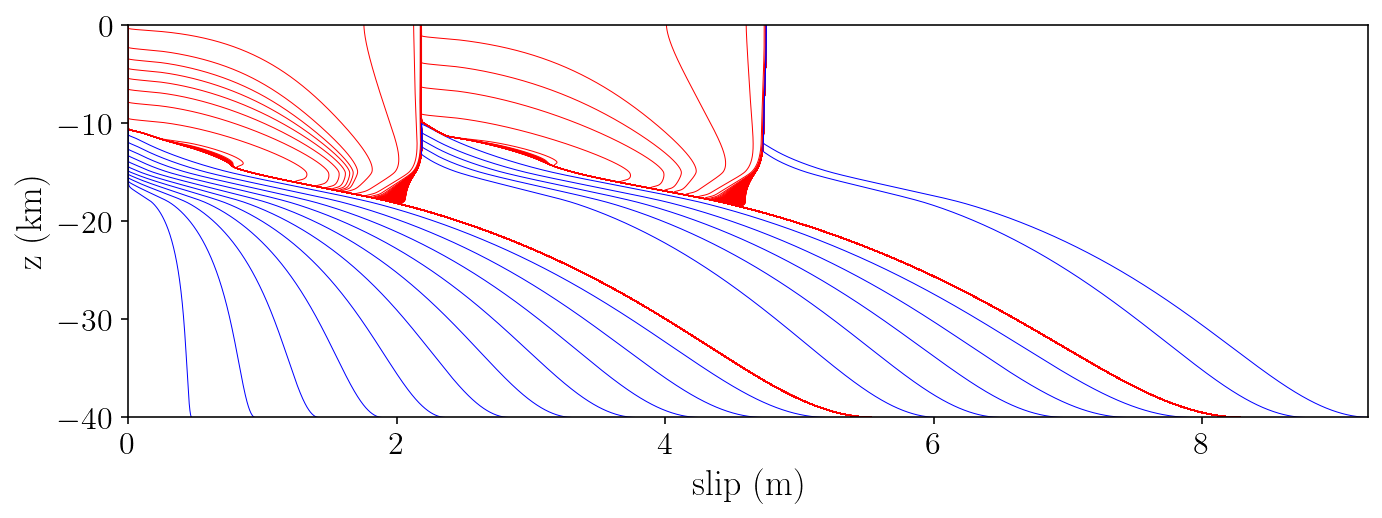

In [22]:
plt.figure(figsize=(10, 4))
last_plt_t = -1000
last_plt_slip = init_slip_deficit
event_times = []
for i in range(len(y_history) - 1):
    y = y_history[i]
    t = t_history[i]
    slip_deficit = y[: init_slip_deficit.shape[0]]
    should_plot = False

    # Plot a red line every three second if the slip rate is over 0.1 mm/s.
    if (
        max_vel[i] >= 0.0001 and t - last_plt_t > 3
    ):
        if len(event_times) == 0 or t - event_times[-1] > siay:
            event_times.append(t)
        should_plot = True
        color = "r"
    
    # Plot a blue line every fifteen years during the interseismic period
    if t - last_plt_t > 15 * siay:
        should_plot = True
        color = "b"

    if should_plot:
        # Convert from slip deficit to slip:
        slip = -slip_deficit + Vp * t
        plt.plot(slip, fd / 1000.0, color + "-", linewidth=0.5)
        last_plt_t = t
        last_plt_slip = slip
plt.xlim([0, np.max(last_plt_slip)])
plt.ylim([-40, 0])
plt.ylabel(r"$\textrm{z (km)}$")
plt.xlabel(r"$\textrm{slip (m)}$")
plt.tight_layout()
plt.savefig("halfspace.png", dpi=300)
plt.show()